In [1]:
import pandas as pd
import numpy as np
import cv2
from keras.utils import Sequence
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, concatenate, Activation, Subtract
from keras.optimizers import RMSprop, Adam
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy, mae
from keras import backend as K
from keras import Sequential
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import concatenate
import random
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!mkdir dataset
!mv seen-dataset.zip dataset
!unzip dataset/seen-dataset.zip -d dataset
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [0]:
!mv shuffled-dataset.zip dataset/
!unzip dataset/shuffled-dataset.zip -d dataset

In [0]:
!mv unseen-dataset.zip dataset/
!unzip dataset/unseen-dataset.zip -d dataset

# Main

In [0]:
# ENV VARS
#stickyPath = "../../dataset/seen-dataset/TrainingSet/"
# For Collab
stickyPath = "./"

In [0]:
lookupSeenTrain = pd.read_csv(str(stickyPath+"dataset/seen-dataset/dataset_seen_training_siamese.csv"))
lookupSeenTrain = lookupSeenTrain.sample(frac=1).reset_index(drop=True)
lookupSeenValidate = pd.read_csv(str(stickyPath+"dataset/seen-dataset/dataset_seen_validation_siamese.csv"))
lookupSeenValidate = lookupSeenValidate.sample(frac=1).reset_index(drop=True)
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))

In [0]:
lookupUnseenTrain = pd.read_csv(str(stickyPath+"dataset/unseen-dataset/dataset_seen_training_siamese.csv"))
lookupUnseenTrain = lookupUnseenTrain.sample(frac=1).reset_index(drop=True)
lookupUnseenTrain = lookupUnseenTrain.iloc[:,1:]
lookupUnseenValidate = pd.read_csv(str(stickyPath+"dataset/unseen-dataset/dataset_seen_validation_siamese.csv"))
lookupUnseenValidate = lookupUnseenValidate.sample(frac=1).reset_index(drop=True)
lookupUnseenValidate = lookupUnseenValidate.iloc[:,1:]

In [0]:
lookupShuffledTrain = pd.read_csv(str(stickyPath+"dataset/shuffled-dataset/dataset_seen_training_siamese.csv"))
lookupShuffledTrain.sample(frac=1).reset_index(drop=True)
lookupShuffledTrain = lookupShuffledTrain.iloc[:,1:]
lookupShuffledValidate = pd.read_csv(str(stickyPath+"dataset/shuffled-dataset/dataset_seen_validation_siamese.csv"))
lookupShuffledValidate = lookupShuffledValidate.sample(frac=1).reset_index(drop=True)
lookupShuffledValidate = lookupShuffledValidate.iloc[:,1:]


In [0]:
class genDataSeen(Sequence):
    def __init__(self,lookupSeenTrain,batchSize,action,flag):
        self.lookupSeenTrain, self.batchSize = lookupSeenTrain,batchSize
        self.action = action
        self.hshift = (-64,64)
        self.vshift = (-64,64)
        self.flag = flag
        if(action=='train'):
            self.stickyPath = "./dataset/seen-dataset/TrainingSet/"
        if(action=='validate'):
            self.stickyPath = "./dataset/seen-dataset/ValidationSet/"
    
    def __len__(self):
        return (int(np.floor(len(self.lookupSeenTrain) / float(self.batchSize))))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = lookupSeenTrain.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self,idx):
        leftImages = list(self.lookupSeenTrain.left[idx*self.batchSize:(idx+1)*self.batchSize])
        rightImages = list(self.lookupSeenTrain.right[idx*self.batchSize:(idx+1)*self.batchSize])
        labels = list(self.lookupSeenTrain.label[idx*self.batchSize:(idx+1)*self.batchSize])
        
        skeleton = []
        for image in range(self.batchSize):
            leftImage = cv2.imread(str(self.stickyPath+
                                       leftImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            rightImage = cv2.imread(str(self.stickyPath+
                                       rightImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = leftImage.astype('float32')
            leftImage /= 255
            rightImage = rightImage.astype('float32')
            rightImage /= 255
            
            # Shifting
            randH = np.random.randint(self.hshift[0],self.hshift[1])
            randV = np.random.randint(self.vshift[0],self.vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)

            # Random Swap
            if(int(np.random.binomial(1, 0.5, 1)) == 1):
                temp = [rightImageShiftedV,leftImageShiftedH]
            else:
                temp = [leftImageShiftedH,rightImageShiftedV]
            skeleton.append(temp)

        skeleton = np.array(skeleton)
        left = []
        left.append(skeleton[:,0,:,:])
        left = np.array(left)
        right = []
        right.append(skeleton[:,1,:,:])
        right = np.array(right)
        if(self.flag=='cnn'):
            left = left.reshape((batchSize,64,64,1))
            right = right.reshape((batchSize,64,64,1))
            return ([left,right],np.array(labels))
        else:
            return ([skeleton[:,0,:,:],skeleton[:,1,:,:]],np.array(labels))

class genDataUnseen(Sequence):
    def __init__(self,lookupSeenTrain,batchSize,action,flag):
        self.lookupSeenTrain, self.batchSize = lookupSeenTrain,batchSize
        self.action = action
        self.hshift = (-64,64)
        self.vshift = (-64,64)
        self.flag = flag
        if(action=='train'):
            self.stickyPath = "./dataset/unseen-dataset/TrainingSet/"
        if(action=='validate'):
            self.stickyPath = "./dataset/unseen-dataset/ValidationSet/"
    
    def __len__(self):
        return (int(np.floor(len(self.lookupSeenTrain) / float(self.batchSize))))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = lookupSeenTrain.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self,idx):
        leftImages = list(self.lookupSeenTrain.left[idx*self.batchSize:(idx+1)*self.batchSize])
        rightImages = list(self.lookupSeenTrain.right[idx*self.batchSize:(idx+1)*self.batchSize])
        labels = list(self.lookupSeenTrain.label[idx*self.batchSize:(idx+1)*self.batchSize])
        
        skeleton = []
        for image in range(self.batchSize):
            leftImage = cv2.imread(str(self.stickyPath+
                                       leftImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            rightImage = cv2.imread(str(self.stickyPath+
                                       rightImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = leftImage.astype('float32')
            leftImage /= 255
            rightImage = rightImage.astype('float32')
            rightImage /= 255
            
            # Shifting
            randH = np.random.randint(self.hshift[0],self.hshift[1])
            randV = np.random.randint(self.vshift[0],self.vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)

            # Random Swap
            if(int(np.random.binomial(1, 0.5, 1)) == 1):
                temp = [rightImageShiftedV,leftImageShiftedH]
            else:
                temp = [leftImageShiftedH,rightImageShiftedV]
            skeleton.append(temp)

        skeleton = np.array(skeleton)
        left = []
        left.append(skeleton[:,0,:,:])
        left = np.array(left)
        right = []
        right.append(skeleton[:,1,:,:])
        right = np.array(right)
        if(self.flag=='cnn'):
            left = left.reshape((batchSize,64,64,1))
            right = right.reshape((batchSize,64,64,1))
            return ([left,right],np.array(labels))
        else:
            return ([skeleton[:,0,:,:],skeleton[:,1,:,:]],np.array(labels))
          

class genDataShuffled(Sequence):
    def __init__(self,lookupSeenTrain,batchSize,action,flag):
        self.lookupSeenTrain, self.batchSize = lookupSeenTrain,batchSize
        self.action = action
        self.hshift = (-64,64)
        self.vshift = (-64,64)
        self.flag = flag
        if(action=='train'):
            self.stickyPath = "./dataset/shuffled-dataset/TrainingSet/"
        if(action=='validate'):
            self.stickyPath = "./dataset/shuffled-dataset/ValidationSet/"
    
    def __len__(self):
        return (int(np.floor(len(self.lookupSeenTrain) / float(self.batchSize))))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = lookupSeenTrain.sample(frac=1).reset_index(drop=True)
    
    def __getitem__(self,idx):
        leftImages = list(self.lookupSeenTrain.left[idx*self.batchSize:(idx+1)*self.batchSize])
        rightImages = list(self.lookupSeenTrain.right[idx*self.batchSize:(idx+1)*self.batchSize])
        labels = list(self.lookupSeenTrain.label[idx*self.batchSize:(idx+1)*self.batchSize])
        
        skeleton = []
        for image in range(self.batchSize):
            leftImage = cv2.imread(str(self.stickyPath+
                                       leftImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            rightImage = cv2.imread(str(self.stickyPath+
                                       rightImages[image]),
                                   cv2.IMREAD_GRAYSCALE)
            # Floating Point
            leftImage = leftImage.astype('float32')
            leftImage /= 255
            rightImage = rightImage.astype('float32')
            rightImage /= 255
            
            # Shifting
            randH = np.random.randint(self.hshift[0],self.hshift[1])
            randV = np.random.randint(self.vshift[0],self.vshift[1])
            
            leftImageShiftedH=np.roll(axis=0,a=leftImage,shift=randH)
            rightImageShiftedH=np.roll(axis=0,a=rightImage,shift=randH)
            
            leftImageShiftedV=np.roll(axis=0,a=leftImage,shift=randV)
            rightImageShiftedV=np.roll(axis=0,a=rightImage,shift=randV)

            # Random Swap
            if(int(np.random.binomial(1, 0.5, 1)) == 1):
                temp = [rightImageShiftedV,leftImageShiftedH]
            else:
                temp = [leftImageShiftedH,rightImageShiftedV]
            skeleton.append(temp)

        skeleton = np.array(skeleton)
        left = []
        left.append(skeleton[:,0,:,:])
        left = np.array(left)
        right = []
        right.append(skeleton[:,1,:,:])
        right = np.array(right)
        if(self.flag=='cnn'):
            left = left.reshape((batchSize,64,64,1))
            right = right.reshape((batchSize,64,64,1))
            return ([left,right],np.array(labels))
        else:
            return ([skeleton[:,0,:,:],skeleton[:,1,:,:]],np.array(labels))

In [0]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [9]:
LOG_DIR = './log/keras/'

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://62ee1b31.ngrok.io


## Baseline Model
From MNIST documentation
Problem of the Model: Stagnant at 50percent accuracy. Maybe we need to decrease the dropout and change the
optimizer

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


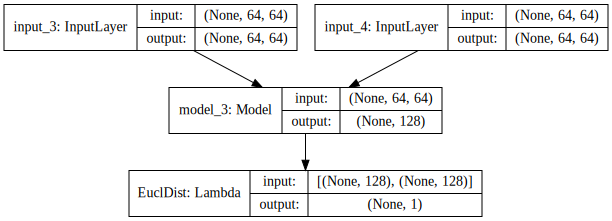

In [26]:
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))
def create_base_network(input_shape):
    '''
    Base network to be shared (eq. to feature extraction).
    Ref: Keras Documentation on MNNIST Siamese
    '''
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(_input, x)
base_network = create_base_network(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = base_network(inputLeft)
processed_right = base_network(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape,name="EuclDist")([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
rms = RMSprop(lr=0.01)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
batchSize = 125
numEpochs = 50
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","nn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","nn")
display(SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Seen

In [0]:
filepath="weights-improvement-seen-baseline-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/seen/baseline/run1', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Shuffled

In [0]:
trainingBatchGen = genDataShuffled(lookupShuffledTrain,batchSize,"train","nn")
validateBatchGen = genDataShuffled(lookupShuffledValidate,batchSize,"validate","nn")
filepath="weights-improvement-shuffled-baseline-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/shuffled/baseline/run1', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupShuffledTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupShuffledValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Unseen

In [0]:
trainingBatchGen = genDataUnseen(lookupUnseenTrain,batchSize,"train","nn")
validateBatchGen = genDataUnseen(lookupUnseenValidate,batchSize,"validate","nn")
filepath="weights-improvement-unseen-baseline-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/unseen/baseline/run1', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupUnseenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupUnseenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

## Modified Baseline
Tried diferent Optimizers and dropped some of the dense layers
Problem: Gives 88% accuracy but I think something might be wrong because it doesn't move and training data is stuck at 50%. The 88% accuracy is random because last time it was around 53%

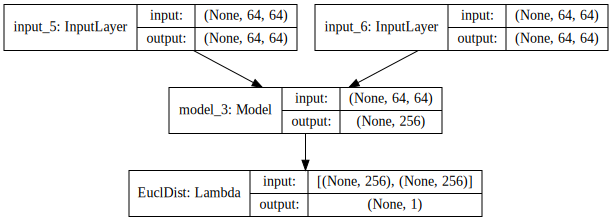

In [18]:
inputShape = np.shape(cv2.imread(str(stickyPath+"dataset/seen-dataset/TrainingSet/0001a_num4.png"),cv2.IMREAD_GRAYSCALE))
def create_base_network(input_shape):
    '''
    Base network to be shared (eq. to feature extraction).
    Ref: Keras Documentation on MNNIST Siamese
    '''
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(256, activation='relu')(x)
    return Model(_input, x)
base_network = create_base_network(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = base_network(inputLeft)
processed_right = base_network(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape,name="EuclDist")([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
model.compile(loss=contrastive_loss, optimizer=Adam(lr=0.1), metrics=[accuracy])
batchSize = 512
numEpochs = 50
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","nn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","nn")
display(SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Seen

In [0]:
filepath="weights-improvement-seen-baselineModified-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/seen/baselineModified/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                    callbacks=[checkpoint,tbCallBack]
                   )

### Shuffled

In [0]:
trainingBatchGen = genDataShuffled(lookupShuffledTrain,batchSize,"train","nn")
validateBatchGen = genDataShuffled(lookupShuffledValidate,batchSize,"validate","nn")
filepath="weights-improvement-shuffled-baselineModified-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/shuffled/baselineModified/run1', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupShuffledTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupShuffledValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                    callbacks=[checkpoint,tbCallBack]
                   )

### Unseen

In [0]:
trainingBatchGen = genDataUnseen(lookupUnseenTrain,batchSize,"train","nn")
validateBatchGen = genDataUnseen(lookupUnseenValidate,batchSize,"validate","nn")
filepath="weights-improvement-unseen-baselineModified-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/unseen/baselineModified/run1', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupUnseenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupUnseenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                    callbacks=[checkpoint,tbCallBack]
                   )

## Model 2 Siamese
This is the first model to use CNN architecture for Siamese Network used MNIST to get it

Instructions for updating:
Colocations handled automatically by placer.


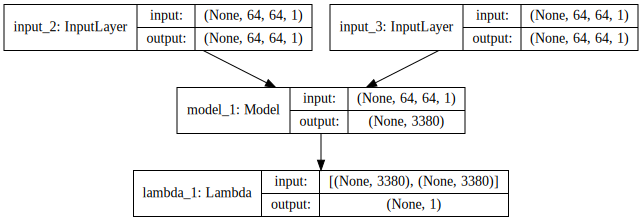

In [10]:
inputShape = (64, 64, 1)
def caffeReplicatedModel(input_shape):
    _input = Input(input_shape)
    x = Conv2D(filters=20,kernel_size=5,
                     kernel_initializer="glorot_normal",
                     strides=1,activation="relu",
                     use_bias=False)(_input)
    x = MaxPooling2D(pool_size=2,strides=2)(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=20,kernel_size=5,
                     kernel_initializer="glorot_normal",
                     strides=1,activation="relu",
                     use_bias=False)(x)
    x = MaxPooling2D(pool_size=2,strides=2)(x)
    x = Flatten()(x)
    return Model(_input, x)
nw2 = caffeReplicatedModel(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = nw2(inputLeft)
processed_right = nw2(inputRight)
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_left, processed_right])
model = Model([inputLeft, inputRight], distance)
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
batchSize = 512
numEpochs = 10
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","cnn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","cnn")
display(SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Seen

In [0]:
tbCallBack = TensorBoard(log_dir='./log/keras/seen/CNNSiamese1/run3', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)
filepath="weights-improvement-seen-CNNSiamese1-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Shuffled

In [0]:
trainingBatchGen = genDataShuffled(lookupShuffledTrain,batchSize,"train","cnn")
validateBatchGen = genDataShuffled(lookupShuffledValidate,batchSize,"validate","cnn")
filepath="weights-improvement-shuffled-CNNSiamese1-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/shuffled/CNNSiamese1/run3', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupShuffledTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupShuffledValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Unseen

In [0]:
trainingBatchGen = genDataUnseen(lookupUnseenTrain,batchSize,"train","cnn")
validateBatchGen = genDataUnseen(lookupUnseenValidate,batchSize,"validate","cnn")
filepath="weights-improvement-unseen-CNNSiamese1-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/unseen/CNNSiamese1/run3', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupUnseenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupUnseenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

## Model from FunctionalModels

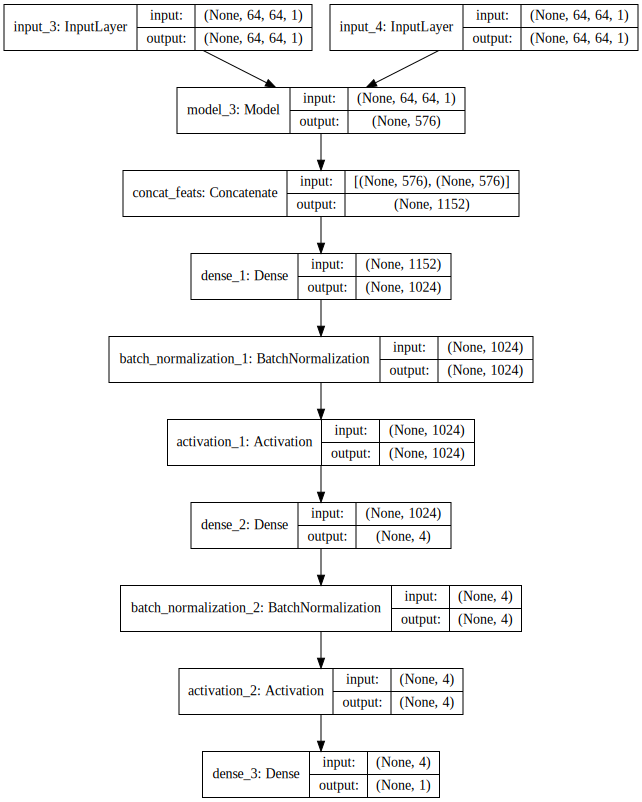

In [15]:
inputShape = (64, 64, 1)
def functionalModel(input_shape):
    _input = Input(input_shape)
    x = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='valid')(_input)
    x = MaxPooling2D((2,2), padding='valid')(x)
    x = Conv2D(64, (3, 3), activation='relu',padding='valid')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    x = Conv2D(128, (3, 3), activation='relu',padding='valid')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    x = Conv2D(256, (1, 1), activation='relu',padding='valid')(x)
    x = MaxPooling2D((2,2),padding='valid')(x)
    x = Conv2D(64, (1, 1), activation='relu',padding='valid')(x)
    x = Flatten()(x)
    return Model(_input, x)
  
nw3 = functionalModel(inputShape)
inputLeft = Input(shape=inputShape)
inputRight = Input(shape=inputShape)
processed_left = nw3(inputLeft)
processed_right = nw3(inputRight)

merged_feats = concatenate([processed_left, processed_right], name = 'concat_feats')
merged_feats = Dense(1024, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(4, activation = 'linear')(merged_feats)
merged_feats = BatchNormalization()(merged_feats)
merged_feats = Activation('relu')(merged_feats)
merged_feats = Dense(1, activation = 'sigmoid')(merged_feats)
similarity_model = Model(inputs = [inputLeft, inputRight], outputs = [merged_feats], name = 'Similarity_Model')

rms = RMSprop()
similarity_model.compile(loss=binary_crossentropy, optimizer=rms, metrics=[binary_accuracy])
batchSize = 512
numEpochs = 10
initialEpoch = 0
trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","cnn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","cnn")
display(SVG(model_to_dot(similarity_model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Seen Dataset

In [0]:
filepath="weights-improvement-seen-functionalModel-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/seen/CNNFunctFeat/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
similarity_model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Shuffled

In [0]:
trainingBatchGen = genDataShuffled(lookupShuffledTrain,batchSize,"train","cnn")
validateBatchGen = genDataShuffled(lookupShuffledValidate,batchSize,"validate","cnn")

filepath="weights-improvement-Shuffled-functionalModel-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='auto')


tbCallBack = TensorBoard(log_dir='./log/keras/shuffled/CNNFunctFeat/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
similarity_model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupSeenValidate) // batchSize),
                    use_multiprocessing=True,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

### Unseen

In [0]:
trainingBatchGen = genDataUnseen(lookupUnseenTrain,batchSize,"train","cnn")
validateBatchGen = genDataUnseen(lookupUnseenValidate,batchSize,"validate","cnn")

filepath="weights-improvement-unseen-functionalModel-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='auto')


tbCallBack = TensorBoard(log_dir='./log/keras/unseen/CNNFunctFeat/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
similarity_model.fit_generator(generator=trainingBatchGen,
                    steps_per_epoch=(len(lookupUnseenTrain) // batchSize),
                    epochs=numEpochs,
                    verbose=1,
                    validation_data=validateBatchGen,
                    validation_steps=(len(lookupUnseenTrain) // batchSize),
                    use_multiprocessing=False,
                    initial_epoch=0,
                    workers=128,
                    max_queue_size=64,
                   callbacks=[checkpoint,tbCallBack])

In [29]:
similarity_model.evaluate_generator(validateBatchGen)

[1.2332632030759538, 0.49888392857142855]

## Best Model

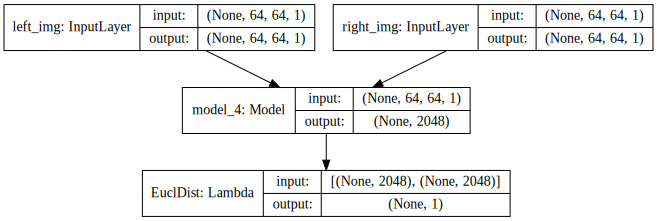

In [30]:
inputShape = (64, 64, 1)

def featureGenCNN(input_shape):
  _input = Input(input_shape)
  layer = Conv2D(32,kernel_size=(3, 3),activation='relu',input_shape=input_shape,padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(_input)
  layer = MaxPooling2D((2,2))(layer)
  layer = Conv2D(64, (3, 3), activation='relu',padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(layer)
  layer = MaxPooling2D((2,2))(layer)
  layer = Conv2D(32, (1, 1), activation='relu',padding='same',
                kernel_regularizer=l1_l2(l1=0.001, l2=0.001), bias_regularizer=l1_l2(l1=0.01, l2=0.01))(layer)
  layer = MaxPooling2D((2,2))(layer)
  layer = Flatten()(layer)
  return Model(_input,layer)

featureGeneratorModel = featureGenCNN(inputShape)
leftDataLayer = Input(shape = inputShape, name = 'left_img')
rightDataLayer = Input(shape = inputShape, name = 'right_img')

left_feats = featureGeneratorModel(leftDataLayer)
right_feats = featureGeneratorModel(rightDataLayer)

distanceLayer = Lambda(euclidean_distance,
                       output_shape=eucl_dist_output_shape,name="EuclDist")([left_feats, right_feats])

siameseDistPlus = Model([leftDataLayer, rightDataLayer], distanceLayer)

rms = RMSprop()

siameseDistPlus.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
display(SVG(model_to_dot(siameseDistPlus, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg')))

### Seen

In [0]:
batchSize = 512
numEpochs = 20
initialEpoch = 0

trainingBatchGen = genDataSeen(lookupSeenTrain,batchSize,"train","cnn")
validateBatchGen = genDataSeen(lookupSeenValidate,batchSize,"validate","cnn")

filepath="weights-improvement-Seen-bestmodel?-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/seen/CNNLastModel/run5', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)


In [0]:
siameseDistPlus.fit_generator(generator=trainingBatchGen,
                              steps_per_epoch=(len(lookupSeenTrain) // batchSize),
                              epochs=numEpochs,
                              verbose=1,
                              validation_data=validateBatchGen,
                              validation_steps=(len(lookupSeenValidate) // batchSize),
                              use_multiprocessing=True,
                              initial_epoch=0,
                              workers=128,
                              max_queue_size=64,
                              callbacks=[checkpoint,tbCallBack])

In [0]:
siameseDistPlus.load_weights("weights-improvement-bestmodel_-18-0.91.hdf5")

In [58]:
siameseDistPlus.evaluate_generator(validateBatchGen)

[0.2560975253582001, 0.728515625]

### Shuffled

In [0]:
trainingBatchGen = genDataShuffled(lookupShuffledTrain,batchSize,"train","cnn")
validateBatchGen = genDataShuffled(lookupShuffledValidate,batchSize,"validate","cnn")
filepath="weights-improvement-shuffled-bestmodel?-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/shuffled/CNNLastModel/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
siameseDistPlus.fit_generator(generator=trainingBatchGen,
                              steps_per_epoch=(len(lookupShuffledTrain) // batchSize),
                              epochs=numEpochs,
                              verbose=1,
                              validation_data=validateBatchGen,
                              validation_steps=(len(lookupShuffledValidate) // batchSize),
                              use_multiprocessing=True,
                              initial_epoch=0,
                              workers=128,
                              max_queue_size=64,
                              callbacks=[checkpoint,tbCallBack])

### Unseen

In [0]:
trainingBatchGen = genDataUnseen(lookupUnseenTrain,batchSize,"train","cnn")
validateBatchGen = genDataUnseen(lookupUnseenValidate,batchSize,"validate","cnn")
filepath="weights-improvement-unseen-bestmodel?-{epoch:02d}-{val_accuracy:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

tbCallBack = TensorBoard(log_dir='./log/keras/unseen/CNNLastModel/run2', histogram_freq=0,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batchSize,
                         write_images=True)

In [0]:
siameseDistPlus.fit_generator(generator=trainingBatchGen,
                              steps_per_epoch=(len(lookupUnseenTrain) // batchSize),
                              epochs=numEpochs,
                              verbose=1,
                              validation_data=validateBatchGen,
                              validation_steps=(len(lookupUnseenValidate) // batchSize),
                              use_multiprocessing=True,
                              initial_epoch=0,
                              workers=128,
                              max_queue_size=64,
                              callbacks=[checkpoint,tbCallBack])